# Bikers on the Fremont bridge
Example adapted from the [Data Science Handbook](https://jakevdp.github.io/PythonDataScienceHandbook/05.06-linear-regression.html)

## Set up: Download (and load) data

In [1]:
# Download data(you can download it by uncommenting and runing this line of code)
# !curl -o FremontBridge.csv https://data.seattle.gov/api/views/65db-xm6k/rows.csv?accessType=DOWNLOAD
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler       # scaling data
from sklearn.model_selection import train_test_split # splitting data
from sklearn.neighbors import KNeighborsRegressor    # regressor
from sklearn.model_selection import GridSearchCV     # for grid search
from sklearn.pipeline import make_pipeline           # for making pipelines
%matplotlib inline

In [2]:
# Aggregate data to the daily level
counts = pd.read_csv('data/FremontBridge.csv', index_col='Date', parse_dates=True)
daily = counts.resample('d').sum()
daily['Total'] = daily.sum(axis=1)
daily = daily[['Total']] # remove other columns

# Data Prep: Adding Features

In [3]:
# Load weather data (downloaded from: https://www.ncdc.noaa.gov/cdo-web/search?datasetid=GHCND)
weather = pd.read_csv('data/weather.csv', index_col='DATE', parse_dates=True)

# Create dry_day column
weather['dry_day'] = (weather['PRCP'] == 0).astype(int)

In [4]:
# Join selected weather columns
daily = daily.join(weather[['PRCP', 'dry_day', 'TMIN', 'TMAX']])

(8, 17)

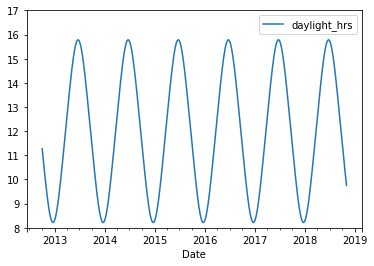

In [5]:
# Compute hours of daylight
def hours_of_daylight(date, axis=23.44, latitude=47.61):
    """Compute the hours of daylight for the given date"""
    days = (date - pd.datetime(2000, 12, 21)).days
    m = (1. - np.tan(np.radians(latitude))
         * np.tan(np.radians(axis) * np.cos(days * 2 * np.pi / 365.25)))
    return 24. * np.degrees(np.arccos(1 - np.clip(m, 0, 2))) / 180.

daily['daylight_hrs'] = list(map(hours_of_daylight, daily.index))
daily[['daylight_hrs']].plot()
plt.ylim(8, 17)

# Feature Generation: Categorical Variable(s)

In [31]:
# Get dummy variables from categorical columns (alternative: sklearn OneHotEncoding)

# Abbreviated EDA

In [32]:
# What is the relationship between bikers and temperature?

In [33]:
# What is the relationship between bikers and date?

In [34]:
# What is the relationship between bikers and (min) temperature?

In [35]:
# What is the distribution of bikers on dry/wet days?

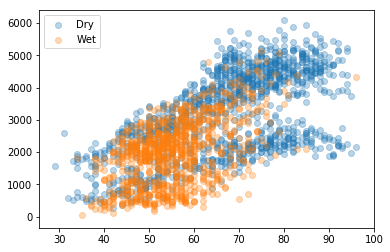

In [11]:
# How does the number of bikers vary by temperature and wet/dry?
plt.figure()
plt.scatter(daily.TMAX[daily.dry_day == True], daily.Total[daily.dry_day == True], alpha = .3, label="Dry")
plt.scatter(daily.TMAX[daily.dry_day == False], daily.Total[daily.dry_day == False], alpha = .3, label="Wet")
plt.legend()

# Modeling: KNN Regressor

In [12]:
# Split data into training and testing data
train_features, test_features, train_outcome, test_outcome = train_test_split(
    daily.drop("Total", axis=1),
    daily.Total,
    test_size=0.30, 
    random_state=11
)

In [18]:
# Create a scaler and your classifier
scaler = MinMaxScaler()
knn_reg = KNeighborsRegressor()

# Define a pipeline that uses your scaler and classifier
pipe = make_pipeline(scaler, knn_reg)

# Define a grid to search through
param_grid = {'kneighborsregressor__n_neighbors':range(1, 5), 'kneighborsregressor__weights':["uniform", "distance"]}

# Perform a  grid search of your pipeline
grid = GridSearchCV(pipe, param_grid, scoring="neg_mean_absolute_error")
grid.fit(train_features, train_outcome)
grid.score(test_features, test_outcome)
grid.best_params_

{'kneighborsregressor__n_neighbors': 4,
 'kneighborsregressor__weights': 'uniform'}

-377.76576576576576

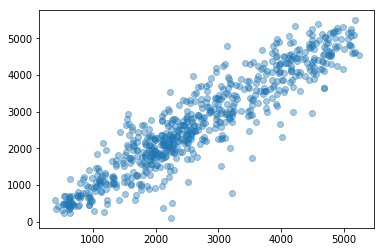

In [19]:
# Compare prediction to (test) data
plt.scatter(grid.predict(test_features), test_outcome, alpha=.4)
grid.score(test_features, test_outcome)

# Feature Generation: Polynomial Transformations

In [20]:
# Add a polynomial transformation to the pipeline
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures()

In [21]:
# Define a pipeline that includes the polynomial transformation
pipe = make_pipeline(poly, scaler, knn_reg)

# Define a grid to search through (including the degree of polynomial)
param_grid = {'polynomialfeatures__degree':range(1, 3), 
              'kneighborsregressor__n_neighbors':range(1, 5), 
              'kneighborsregressor__weights':["uniform", "distance"]}

# Perform a  grid search of your pipeline
grid = GridSearchCV(pipe, param_grid, scoring="neg_mean_absolute_error")
grid.fit(train_features, train_outcome)
grid.score(test_features, test_outcome)

-377.0908408408408

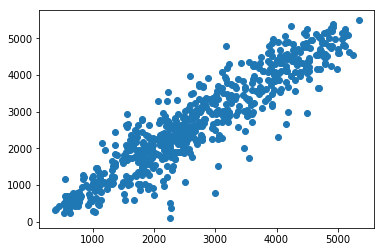

In [22]:
plt.scatter(grid.predict(test_features), test_outcome)

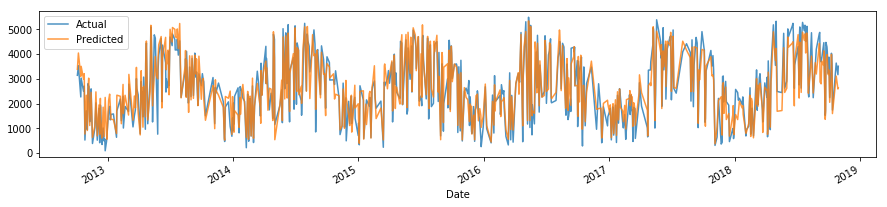

In [23]:
# Visualize time trends
test_data = test_features.join(test_outcome)
test_data['preds'] = grid.predict(test_features)
plt.figure(figsize=(15, 3))
test_data.Total.plot(label="Actual", alpha = .8)
test_data.preds.plot(label="Predicted", alpha = .8)
plt.legend()

# Error assessment: find systematic errors

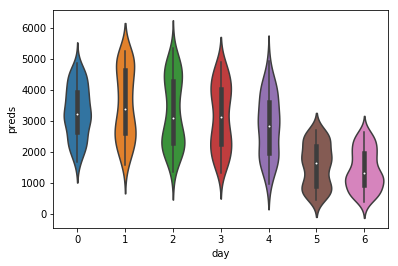

In [26]:
# Why are we getting this wrong? -- UNSURE WHY THIS ISN'T WORKING
# Assess error by day of the week
test_data['day'] = test_data.index.dayofweek
test_data['err'] = test_data.Total - test_data.preds
sns.violinplot(y="preds", x="day", data=test_data)

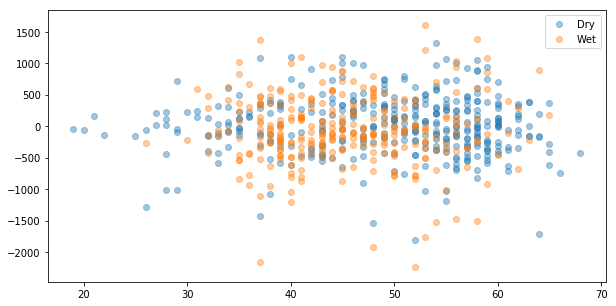

In [27]:
# Assess error by temperature and dry_day
plt.figure(figsize=(10, 5))
plt.scatter(test_data.TMIN[test_data.dry_day == True], test_data.err[test_data.dry_day == True], alpha=.4, label="Dry")
plt.scatter(test_data.TMIN[test_data.dry_day == False], test_data.err[test_data.dry_day == False], alpha=.4, label="Wet")
plt.legend()

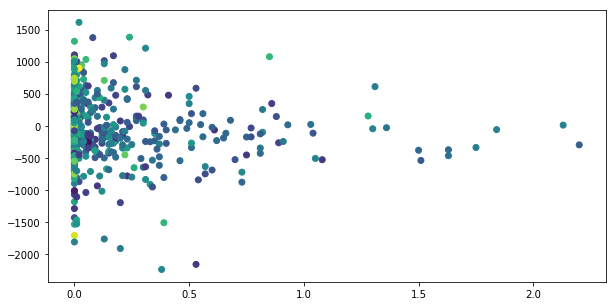

In [28]:
# Assess error by precipitation
plt.figure(figsize=(10, 5))
plt.scatter(test_data.PRCP, test_data.err, c=test_data.TMAX)

# Feature Selection: Select best features
As a form of dimensionality reduction, only select the top percentile features that have a certain threshold of variance.

In [29]:
# Create a percentile selector, add it to the pipeline
# (alternatives a K selectors, PCA, or others)
from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import VarianceThreshold
selecter = SelectPercentile()
threshold = VarianceThreshold(.1)
pipe = make_pipeline(poly, threshold, scaler, selecter, knn_reg)

# Define a grid to search through (including the degree of polynomial AND percentile of best features)
param_grid = {
              'polynomialfeatures__degree':range(1, 3),
              'selectpercentile__percentile':range(10, 30, 5),
              'kneighborsregressor__n_neighbors':range(1, 5), 
              'kneighborsregressor__weights':["uniform", "distance"]
}

In [30]:
grid = GridSearchCV(pipe, param_grid, scoring="neg_mean_absolute_error")
grid.fit(train_features, train_outcome)
grid.score(test_features, test_outcome)

-849.774024024024